# Atividade 6
Crie a sua heurística para escolher a melhor característica para um nó de uma árvore de decisão e compare com a implementação feita nos vídeos postados nesse tópico aqui no AVA e com a implementação do scikit learn.

Faça comparações plotando as regiões de decisão com resubstituição para a base iris e as características usadas nos vídeos.

Também faça comparações usando validação cruzada com pelo menos 3 bases de classificação com atributos contínuos.

Escreva um parágrafo expondo sua interpretação dos resultados obtidos.

# Resposta Parágrafo

Em resumo, o método Arvore do ScikitLearn é completo pois consegue dividir a Heuristica do nó considerando os eixos X e Y, O método proposto criar um limiar entre o ponto maximo e mínimo, então propuz fazer um experimento considerando a média, uma vez que os target estão consideravelmente distantes um dos outros. Deste modo, podemos definir uma boa heuristica para os Dataset selecionados.

# Algoritmos

## Bibliotecas e Funções

In [1]:
# Bibliotecas
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.metrics import accuracy_score


In [2]:
# Função para gráfico
import matplotlib.pyplot as plt
import pandas as pd

def plotDecisao(modelo, X, y, title):
    modelo.fit(X, y)
    x0s = np.linspace(np.min(X[:,0])-0.2, np.max(X[:,0])+0.2, 100)
    x1s = np.linspace(np.min(X[:,1])-0.2, np.max(X[:,1])+0.2, 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    Xdec = np.c_[x0.ravel(), x1.ravel()]
    ypred = modelo.predict(Xdec)
    plt.contourf(x0, x1, ypred.reshape(x0.shape), alpha=0.25)
    for k in set(y):
        plt.plot(X[:,0][y==k], X[:,1][y==k], 'o', label=f"{iris.target_names[k]} [{k}]")
    plt.xlabel(f"X[0]: {iris.feature_names[0]}")
    plt.ylabel(f"X[1]: {iris.feature_names[1]}")
    plt.title(f'{title}')
    plt.show()



## Base de Dados iris

In [3]:
from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris.data[:,2:], iris.target[:]

## Heuristicas, SkLearn, Video e Matheus

### Heuristica do ScikitLearnn

In [4]:
from sklearn import tree

ArvoreSK = tree.DecisionTreeClassifier() # DecisionTreeRegressor()

ArvoreSK.fit(X, y)
ypred = ArvoreSK.predict(X)
accSK = accuracy_score(y, ypred),# (ypred == y)
accSK

(0.9933333333333333,)

In [5]:
# Validação Cruzada.
scoresSK = cross_validate(ArvoreSK, X, y, scoring=make_scorer
(mean_squared_error, greater_is_better=False, squared=False))
print(scoresSK['test_score'])

[-0.18257419 -0.18257419 -0.31622777 -0.25819889 -0.        ]


### Heuristica do vídeo Passado

In [6]:
from sklearn.metrics import accuracy_score
import numpy as np
from collections import Counter
from sklearn.base import BaseEstimator, ClassifierMixin

def impureza(y): #Gini
    labels = list(set(y))
    labels.sort()
    probabilidades = np.zeros((len(labels),))
    for i,k in enumerate(labels):
        probabilidades[i] = sum(y==k)/len(y)
    result = 1 - sum(probabilidades**2) # Resultado = 0, quer dizer que é puro
    return result

def impurezaValor(x, y, valor):
    iguais = x==valor
    impurezaIguais = impureza(y[iguais])
    propIguais = sum(iguais)/len(y)
    impurezaDiferentes = impureza(y[~iguais])
    propDiferentes = sum(~iguais)/len(y)
    impurezaTotal = propIguais*impurezaIguais + propDiferentes*impurezaDiferentes
    return impurezaTotal

def impurezaMinima(X, y):
    impurezas = []
    caracteristicasValores = []
    for i in range(X.shape[1]):
        valores = sorted(list(set(X[:,i])))
        for valor in valores:
            caracteristicasValores.append([i,valor])
            impurezasValorCaracteristica = impurezaValor(X[:,i], y, valor)
            impurezas.append(impurezasValorCaracteristica)
    caracteristicasValores = np.array(caracteristicasValores)
    impurezas = np.array(impurezas)
    menorimpureza = np.argmin(impurezas)
    caracteristica, valor = caracteristicasValores[menorimpureza]
    return impurezas[menorimpureza], int(caracteristica), valor

def maisFrequente(y):
    return Counter(y.flat).most_common(1)[0][0]

class ArvoreVD(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.caracteristica = 0
    def fit(self, X, y):
        self.valor = np.mean(X[:,self.caracteristica])
        maiores = X[:,self.caracteristica] > self.valor
        if sum(maiores)>0 and sum(~maiores)>0:
            self.maiores = ArvoreVD()
            self.maiores.fit(X[maiores,:],y[maiores])
            self.menores = ArvoreVD()
            self.menores.fit(X[~maiores,:],y[~maiores])
        else:
            self.resposta = maisFrequente(y)
    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            maiores = X[:,self.caracteristica] > self.valor
            y[maiores] = self.maiores.predict(X[maiores,:])
            y[~maiores] = self.menores.predict(X[~maiores,:])
        return y

modelo = ArvoreVD()
modelo.fit(X,y)
ypred = modelo.predict(X)
accVD = accuracy_score(y, ypred)#, (ypred == y)
accVD 

0.9533333333333334

In [7]:
# Validação Cruzada.
scoresVD = cross_validate(ArvoreVD(), X, y, scoring=make_scorer
(mean_squared_error, greater_is_better=False, squared=False))
print(scoresVD['test_score'])

[-0.25819889 -0.25819889 -0.4472136  -0.25819889 -0.        ]


### Heuristica Matheus

In [8]:
from sklearn.metrics import accuracy_score
import numpy as np
from collections import Counter
from sklearn.base import BaseEstimator, ClassifierMixin

def impureza(y): #Gini
    labels = list(set(y))
    labels.sort()
    probabilidades = np.zeros((len(labels),))
    for i,k in enumerate(labels):
        probabilidades[i] = sum(y==k)/len(y)
    result = 1 - sum(probabilidades**2)
    return result

def impurezaValor(x, y, valor):
    maiores = x>valor
    impurezaMaiores = impureza(y[maiores])
    propMaiores = sum(maiores)/len(y)
    impurezaMenores = impureza(y[~maiores])
    propMenores = sum(~maiores)/len(y)
    impurezaTotal = propMaiores*impurezaMaiores + propMenores*impurezaMenores
    return impurezaTotal, impurezaMaiores, impurezaMenores

# A alteração está aqui.
# Para base que escolhi a melhor classificação seria pelo y e não pelo x.

def melhorValor(x, y):
    result = None
    menorImpureza = float('inf')
    xmax = np.mean(x)
    xmin = np.mean(x)
    while True:
        valor = (xmin+xmax)/2
        impTotal, impMaiores, impMenores = impurezaValor(x, y, valor)
        if impTotal < menorImpureza:
            menorImpureza = impTotal
            result = valor
            if impMaiores == 0 or impMenores == 0:
                break
            if impMaiores < impMenores:
                xmin = valor
            else:
                xmax = valor
        else:
            break
    return result, menorImpureza


def melhorCaracteristica(X, y):
    impurezas = []
    valores = []
    for caracteristica in range(X.shape[1]):
        valor, imp = melhorValor(X[:,caracteristica], y)
        impurezas.append(imp)
        valores.append(valor)
    impurezas = np.array(impurezas)
    caracteristica = np.argmin(impurezas)
    return caracteristica, valores[caracteristica], impurezas[caracteristica]

def impurezaMinima(X, y):
    impurezas = []
    caracteristicasValores = []
    for i in range(X.shape[1]):
        valores = sorted(list(set(X[:,i])))
        for valor in valores:
            caracteristicasValores.append([i,valor])
            impurezasValorCaracteristica = impurezaValor(X[:,i], y, valor)
            impurezas.append(impurezasValorCaracteristica)
    caracteristicasValores = np.array(caracteristicasValores)
    impurezas = np.array(impurezas)
    menorimpureza = np.argmin(impurezas)
    caracteristica, valor = caracteristicasValores[menorimpureza]
    return impurezas[menorimpureza], int(caracteristica), valor

def maisFrequente(y):
    return Counter(y.flat).most_common(1)[0][0]

class ArvoreMT(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        self.caracteristica, self.valor, self.imp = melhorCaracteristica(X,y)
        maiores = X[:,self.caracteristica] > self.valor
        if sum(maiores)>0 and sum(~maiores)>0:
            self.maiores = ArvoreMT()
            self.maiores.fit(X[maiores,:],y[maiores])
            self.menores = ArvoreMT()
            self.menores.fit(X[~maiores,:],y[~maiores])
        else:
            self.resposta = maisFrequente(y)
    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            maiores = X[:,self.caracteristica] > self.valor
            y[maiores] = self.maiores.predict(X[maiores,:])
            y[~maiores] = self.menores.predict(X[~maiores,:])
        return y

modelo = ArvoreMT()
modelo.fit(X,y)
ypred = modelo.predict(X)
accMT = accuracy_score(y, ypred)#, (ypred == y)
accMT

0.9933333333333333

In [9]:
# Validação Cruzada.
scoresMT = cross_validate(ArvoreMT(), X, y, scoring=make_scorer
(mean_squared_error, greater_is_better=False, squared=False))
print(scoresMT['test_score'])

[-0.18257419 -0.         -0.25819889 -0.36514837 -0.        ]


## Comparação de Resultados

In [10]:
# Acurácia
print(f"Acurácia Heuristica ScikitLearn         : {accSK}")
print(f"Acurácia Cruzada Heuristica Vídeo       : {accVD}")
print(f"Acurácia Cruzada Heuristica Matheus     : {accMT}")

Acurácia Heuristica ScikitLearn         : (0.9933333333333333,)
Acurácia Cruzada Heuristica Vídeo       : 0.9533333333333334
Acurácia Cruzada Heuristica Matheus     : 0.9933333333333333


In [11]:
# Validação Cruzada
print(f"Validação Cruzada Heuristica ScikitLearn : {scoresSK['test_score']}")
print(f"Validação Cruzada Heuristica Vídeo       : {scoresVD['test_score']}")
print(f"Validação Cruzada Heuristica Matheus     : {scoresMT['test_score']}")

Validação Cruzada Heuristica ScikitLearn : [-0.18257419 -0.18257419 -0.31622777 -0.25819889 -0.        ]
Validação Cruzada Heuristica Vídeo       : [-0.25819889 -0.25819889 -0.4472136  -0.25819889 -0.        ]
Validação Cruzada Heuristica Matheus     : [-0.18257419 -0.         -0.25819889 -0.36514837 -0.        ]


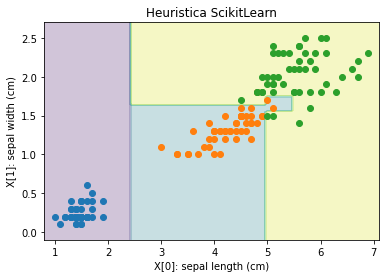

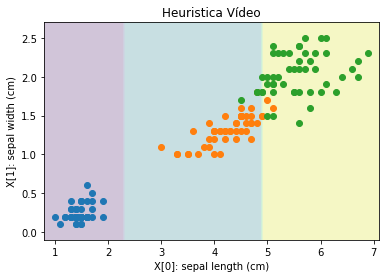

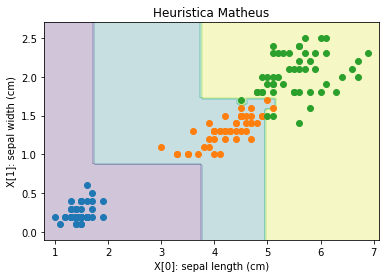

In [12]:
# Gráficos dos métodos heurísticos
plotDecisao(tree.DecisionTreeClassifier(), X, y, "Heuristica ScikitLearn")
plotDecisao(ArvoreVD(), X, y, "Heuristica Vídeo")
plotDecisao(ArvoreMT(), X, y, "Heuristica Matheus")

## Resultados com Outras bases de Dados

In [13]:
# Heuristica Matheus
from sklearn.metrics import accuracy_score
import numpy as np
from collections import Counter
from sklearn.base import BaseEstimator, ClassifierMixin

def impureza(y): #Gini
    labels = list(set(y))
    labels.sort()
    probabilidades = np.zeros((len(labels),))
    for i,k in enumerate(labels):
        probabilidades[i] = sum(y==k)/len(y)
    result = 1 - sum(probabilidades**2)
    return result

def impurezaValor(x, y, valor):
    maiores = x>valor
    impurezaMaiores = impureza(y[maiores])
    propMaiores = sum(maiores)/len(y)
    impurezaMenores = impureza(y[~maiores])
    propMenores = sum(~maiores)/len(y)
    impurezaTotal = propMaiores*impurezaMaiores + propMenores*impurezaMenores
    return impurezaTotal, impurezaMaiores, impurezaMenores

# A alteração está aqui.
# Para base que escolhi a melhor classificação seria pelo y e não pelo x.

def melhorValor(x, y): 
    result = None
    menorImpureza = float('inf')
    ymax = np.max(y)
    ymin = np.min(y)
    while True:
        valor = (ymin+ymax)/2
        impTotal, impMaiores, impMenores = impurezaValor(x, y, valor)
        if impTotal < menorImpureza:
            menorImpureza = impTotal
            result = valor
            if impMaiores == 0 or impMenores == 0:
                break
            if impMaiores < impMenores:
                ymin = valor
            else:
                ymax = valor
        else:
            break
    return result, menorImpureza

def melhorCaracteristica(X, y):
    impurezas = []
    valores = []
    for caracteristica in range(X.shape[1]):
        #valor, imp = melhorValor(X[:,caracteristica], y)
        valor, imp = melhorValor(X, y)
        impurezas.append(imp)
        valores.append(valor)
    impurezas = np.array(impurezas)
    caracteristica = np.argmin(impurezas)
    return caracteristica, valores[caracteristica], impurezas[caracteristica]

def impurezaMinima(X, y):
    impurezas = []
    caracteristicasValores = []
    for i in range(X.shape[1]):
        valores = sorted(list(set(X[:,i])))
        for valor in valores:
            caracteristicasValores.append([i,valor])
            impurezasValorCaracteristica = impurezaValor(X[:,i], y, valor)
            impurezas.append(impurezasValorCaracteristica)
    caracteristicasValores = np.array(caracteristicasValores)
    impurezas = np.array(impurezas)
    menorimpureza = np.argmin(impurezas)
    caracteristica, valor = caracteristicasValores[menorimpureza]
    return impurezas[menorimpureza], int(caracteristica), valor

def maisFrequente(y):
    return Counter(y.flat).most_common(1)[0][0]

class ArvoreMT(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        self.caracteristica, self.valor, self.imp = melhorCaracteristica(X,y)
        maiores = X[:,self.caracteristica] > self.valor
        if sum(maiores)>0 and sum(~maiores)>0:
            self.maiores = ArvoreMT()
            self.maiores.fit(X[maiores,:],y[maiores])
            self.menores = ArvoreMT()
            self.menores.fit(X[~maiores,:],y[~maiores])
        else:
            self.resposta = maisFrequente(y)
    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            maiores = X[:,self.caracteristica] > self.valor
            y[maiores] = self.maiores.predict(X[maiores,:])
            y[~maiores] = self.menores.predict(X[~maiores,:])
        return y


### Base 1 - Mobile Price Classification

In [13]:
# Base de classificação com atributos continuos
# https://archive.ics.uci.edu/ml/datasets/Haberman%27s+Survival

df = pd.read_csv("C:/Users/mathe/Desktop/Aula REPA/atividade 5/Mobile Price Classification train.csv")
df.head(5)

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [14]:
# Abrir as chaves 
df.keys

<bound method NDFrame.keys of       battery_power  blue  clock_speed  dual_sim  fc  four_g  int_memory  \
0               842     0          2.2         0   1       0           7   
1              1021     1          0.5         1   0       1          53   
2               563     1          0.5         1   2       1          41   
3               615     1          2.5         0   0       0          10   
4              1821     1          1.2         0  13       1          44   
...             ...   ...          ...       ...  ..     ...         ...   
1995            794     1          0.5         1   0       1           2   
1996           1965     1          2.6         1   0       0          39   
1997           1911     0          0.9         1   1       1          36   
1998           1512     0          0.9         0   4       1          46   
1999            510     1          2.0         1   5       1          45   

      m_dep  mobile_wt  n_cores  ...  px_height  px_width

In [15]:
# Quantidade dos dados
df.shape

(2000, 21)

In [31]:
# Divisão em Dados e Target
X = df.iloc[:, :-1]
y = df.iloc[:, -1]


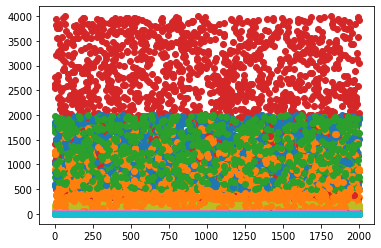

In [26]:
# Plotar gráfico
#plt.xlabel(f"pctid")
#plt.ylabel(f"wconfid")
for k in set(y):
    plt.plot(X[:][y==k], "o", label=f"{y[k]}")
#plt.legend()
plt.show()

In [33]:
X = X.values
y = y.values

In [34]:
# Acurácia

import numpy as np

# Acurácia Scikitlearn
ArvoreSK.fit(X, y)
ypred = ArvoreSK.predict(X)
accSK = accuracy_score(y, ypred),# (ypred == y)
accSK

# Acurácia Video
modelo = ArvoreVD()
modelo.fit(X,y)
ypred = modelo.predict(X)
accVD = accuracy_score(y, ypred)#, (ypred == y)
accVD 

# Acurácia Matheus
modelo = ArvoreMT()
modelo.fit(X,y)
ypred = modelo.predict(X)
accMT = accuracy_score(y, ypred)#, (ypred == y)
accMT

1.0

In [35]:
# Print Acuracia
print(f"Acurácia Heuristica ScikitLearn         : {accSK}")
print(f"Acurácia Cruzada Heuristica Vídeo       : {accVD}")
print(f"Acurácia Cruzada Heuristica Matheus     : {accMT}")

Acurácia Heuristica ScikitLearn         : (1.0,)
Acurácia Cruzada Heuristica Vídeo       : 0.7055
Acurácia Cruzada Heuristica Matheus     : 1.0


In [36]:
# Validação Cruzada

# Validação Cruzada Scikitlearn
scoresSK = cross_validate(ArvoreSK, X, y, scoring=make_scorer
(mean_squared_error, greater_is_better=False, squared=False))
# Validação Cruzada Video
scoresVD = cross_validate(ArvoreVD(), X, y, scoring=make_scorer
(mean_squared_error, greater_is_better=False, squared=False))
# Validação Cruzada Matheus
scoresMT = cross_validate(ArvoreMT(), X, y, scoring=make_scorer
(mean_squared_error, greater_is_better=False, squared=False))

print(f"Validação Cruzada Heuristica ScikitLearn : {scoresSK['test_score']}")
print(f"Validação Cruzada Heuristica Vídeo       : {scoresVD['test_score']}")
print(f"Validação Cruzada Heuristica Matheus     : {scoresMT['test_score']}")

Validação Cruzada Heuristica ScikitLearn : [-0.38729833 -0.42426407 -0.42720019 -0.42426407 -0.41833001]
Validação Cruzada Heuristica Vídeo       : [-1.51657509 -1.52970585 -1.57241852 -1.60545944 -1.51244835]
Validação Cruzada Heuristica Matheus     : [-0.40926764 -0.46368092 -0.40311289 -0.46097722 -0.42130749]


### Base 2 - Breast Cancer Coimbra Data Set

In [25]:
import pandas as pd
#df1 = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00601/ai4i2020.csv")
#df1 = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv")
#df1 = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/blood-transfusion/transfusion.data")
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00451/dataR2.csv")
df

,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1,Classification
0,48,23.500000,70,2.707,0.467409,8.8071,9.702400,7.99585,417.114,1
1,83,20.690495,92,3.115,0.706897,8.8438,5.429285,4.06405,468.786,1
2,82,23.124670,91,4.498,1.009651,17.9393,22.432040,9.27715,554.697,1
3,68,21.367521,77,3.226,0.612725,9.8827,7.169560,12.76600,928.220,1
4,86,21.111111,92,3.549,0.805386,6.6994,4.819240,10.57635,773.920,1
...,...,...,...,...,...,...,...,...,...,...
111,45,26.850000,92,3.330,0.755688,54.6800,12.100000,10.96000,268.230,2
112,62,26.840000,100,4.530,1.117400,12.4500,21.420000,7.32000,330.160,2
113,65,32.050000,97,5.730,1.370998,61.4800,22.540000,10.33000,314.050,2
114,72,25.590000,82,2.820,0.570392,24.9600,33.750000,3.27000,392.460,2


In [26]:
df.keys()

Index(['Age', 'BMI', 'Glucose', 'Insulin', 'HOMA', 'Leptin', 'Adiponectin',
       'Resistin', 'MCP.1', 'Classification'],
      dtype='object')

In [27]:
X, y = df.Age, df.Classification

X.shape, y.shape, set(y) # temos 3 variaveis

((116,), (116,), {1, 2})

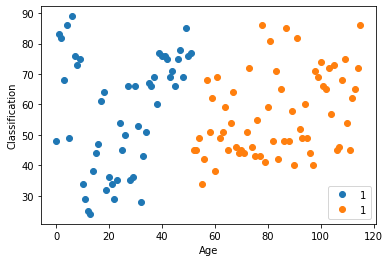

In [28]:
import matplotlib.pyplot as plt
# Plotar gráfico
plt.xlabel(f"Age")
plt.ylabel(f"Classification")
for k in set(y):
    plt.plot(X[:][y==k], "o", label=f"{y[k]}")
plt.legend()
plt.show()

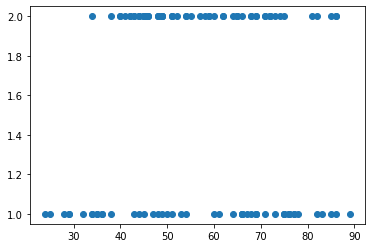

In [29]:
X2 = df["Age"].values
y2 = df["Classification"].values

plt.scatter(X2,y2)
plt.show()

In [30]:
# Função Reshape
X = X2.reshape(-1,1)
y = y2.reshape(-1,1)
y

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
    

In [31]:
# Acurácia

import numpy as np

# Acurácia Scikitlearn
ArvoreSK.fit(X, y)
ypred = ArvoreSK.predict(X)
accSK = accuracy_score(y, ypred),# (ypred == y)
accSK

# Acurácia Video
modelo = ArvoreVD()
modelo.fit(X,y)
ypred = modelo.predict(X)
accVD = accuracy_score(y, ypred)#, (ypred == y)
accVD 

# Acurácia Matheus
modelo = ArvoreMT()
modelo.fit(X,y)
ypred = modelo.predict(X)
accMT = accuracy_score(y, ypred)#, (ypred == y)
accMT

0.5517241379310345

In [32]:
# Print Acuracia
print(f"Acurácia Heuristica ScikitLearn         : {accSK}")
print(f"Acurácia Cruzada Heuristica Vídeo       : {accVD}")
print(f"Acurácia Cruzada Heuristica Matheus     : {accMT}")

Acurácia Heuristica ScikitLearn         : (0.8189655172413793,)
Acurácia Cruzada Heuristica Vídeo       : 0.8189655172413793
Acurácia Cruzada Heuristica Matheus     : 0.5517241379310345


In [33]:
# Validação Cruzada

# Validação Cruzada Scikitlearn
scoresSK = cross_validate(ArvoreSK, X, y, scoring=make_scorer
(mean_squared_error, greater_is_better=False, squared=False))
# Validação Cruzada Video
scoresVD = cross_validate(ArvoreVD(), X, y, scoring=make_scorer
(mean_squared_error, greater_is_better=False, squared=False))
# Validação Cruzada Matheus
scoresMT = cross_validate(ArvoreMT(), X, y, scoring=make_scorer
(mean_squared_error, greater_is_better=False, squared=False))

print(f"Validação Cruzada Cruzada Heuristica ScikitLearn : {scoresSK['test_score']}")
print(f"Validação Cruzada Cruzada Heuristica Vídeo       : {scoresVD['test_score']}")
print(f"Validação Cruzada Cruzada Heuristica Matheus     : {scoresMT['test_score']}")

Validação Cruzada Heuristica ScikitLearn : [-0.73598007 -0.55167728 -0.72231512 -0.58976782 -0.62554324]
Validação Cruzada Heuristica Vídeo       : [-0.73598007 -0.55167728 -0.72231512 -0.62554324 -0.62554324]
Validação Cruzada Heuristica Matheus     : [-0.6770032  -0.69156407 -0.65938047 -0.65938047 -0.65938047]


### Base 3 - TUANDROMD ( Tezpur University Android Malware Dataset) Data Set

In [34]:
import pandas as pd
#df1 = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00476/buddymove_holidayiq.csv")
#df1 = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00523/Exasens.csv")
#df1 = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data")
#df1 = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00485/google_review_ratings.csv")
#df1 = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00484/tripadvisor_review.csv")
#df1 = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00622/TUANDROMD.csv")
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00476/buddymove_holidayiq.csv")
df

,User Id,Sports,Religious,Nature,Theatre,Shopping,Picnic
0,User 1,2,77,79,69,68,95
1,User 2,2,62,76,76,69,68
2,User 3,2,50,97,87,50,75
3,User 4,2,68,77,95,76,61
4,User 5,2,98,54,59,95,86
...,...,...,...,...,...,...,...
244,User 245,18,139,148,129,129,168
245,User 246,22,114,228,104,84,168
246,User 247,20,124,178,104,158,174
247,User 248,20,133,149,139,144,213


In [35]:
y, X = df.Sports, df.Nature

X.shape, y.shape, set(y) # temos 3 variaveis

((249,), (249,), {2, 3, 4, 5, 6, 8, 10, 12, 14, 16, 18, 20, 22, 25})

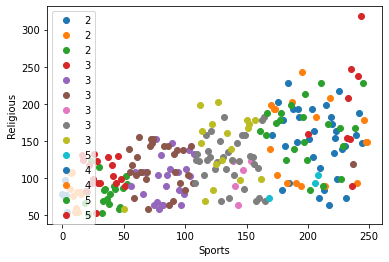

In [36]:
import matplotlib.pyplot as plt
# Plotar gráfico
plt.xlabel(f"Sports")
plt.ylabel(f"Religious")
for k in set(y):
    plt.plot(X[:][y==k], "o", label=f"{y[k]}")
plt.legend()
plt.show()

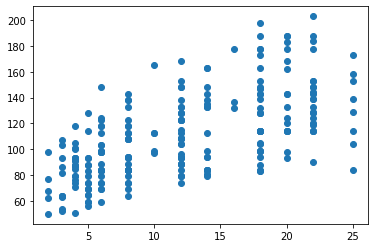

In [37]:
X2 = df["Sports"].values
y2 = df["Religious"].values

plt.scatter(X2,y2)
plt.show()

In [38]:
# Função Reshape
X = X2.reshape(-1,1)
y = y2.reshape(-1,1)

In [39]:
# Acurácia

import numpy as np

# Acurácia Scikitlearn
ArvoreSK.fit(X, y)
ypred = ArvoreSK.predict(X)
accSK = accuracy_score(y, ypred),# (ypred == y)
accSK

# Acurácia Video
modelo = ArvoreVD()
modelo.fit(X,y)
ypred = modelo.predict(X)
accVD = accuracy_score(y, ypred)#, (ypred == y)
accVD 

# Acurácia Matheus
modelo = ArvoreMT()
modelo.fit(X,y)
ypred = modelo.predict(X)
accMT = accuracy_score(y, ypred)#, (ypred == y)
accMT

0.06827309236947791

In [40]:
# Print Acuracia
print(f"Acurácia Heuristica ScikitLearn         : {accSK}")
print(f"Acurácia Cruzada Heuristica Vídeo       : {accVD}")
print(f"Acurácia Cruzada Heuristica Matheus     : {accMT}")

Acurácia Heuristica ScikitLearn         : (0.18473895582329317,)
Acurácia Cruzada Heuristica Vídeo       : 0.18473895582329317
Acurácia Cruzada Heuristica Matheus     : 0.06827309236947791


In [41]:
# Validação Cruzada

# Validação Cruzada Scikitlearn
scoresSK = cross_validate(ArvoreSK, X, y, scoring=make_scorer
(mean_squared_error, greater_is_better=False, squared=False))
# Validação Cruzada Video
scoresVD = cross_validate(ArvoreVD(), X, y, scoring=make_scorer
(mean_squared_error, greater_is_better=False, squared=False))
# Validação Cruzada Matheus
scoresMT = cross_validate(ArvoreMT(), X, y, scoring=make_scorer
(mean_squared_error, greater_is_better=False, squared=False))

print(f"Validação Cruzada Heuristica ScikitLearn : {scoresSK['test_score']}")
print(f"Validação Cruzada Heuristica Vídeo       : {scoresVD['test_score']}")
print(f"Validação Cruzada Heuristica Matheus     : {scoresMT['test_score']}")

c:\Users\mathe\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\mathe\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\mathe\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Validação Cruzada Heuristica ScikitLearn : [-38.31605408 -27.2572926  -35.38502508 -38.85871846 -29.1935833 ]
Validação Cruzada Heuristica Vídeo       : [-35.93048845 -27.20183817 -30.62058131 -37.94654134 -31.13335373]
Validação Cruzada Heuristica Matheus     : [-46.12678181 -38.57486228 -42.38702632 -38.81211151 -40.59506354]
